# Introduction #

This is an interactive demonstration to accompany the manuscript XX. In the manuscript, a bagged regression tree (an ensemble variation of the decision tree applied to continuous data), is applied to correct wave forecasts.

The following notebook encompasses:


**Application of the Bagged Regression Tree**
1. The dataset
2. Training and testing the bagged regression tree

**Explanation of the Results**
1. Regression tree theory 
2. Regression tree architecture
3. Dataset partitions



# Wave Data #



## Data As Time Series

The dataset is comprised of WW3 output and buoy observations at Stonewall Banks NDBC buoy 46050. 

>The elements of the hourly input feature vectors ($\mathbf{x}_i$) are modelled environmental parameters associated with the forecast for that hour, $i$. These include significant wave height, $Hs$, mean wave direction, $MWD$, mean period $T_m$, wind magnitude, $wndmag$, and wind direction $winddir$. The output target ($y_i$) for this study is the difference between the wave height observations, $H_{s,obs}$, and modelled wave height, $H_{s,WW3}$ for a particular hour, $i$:
    \begin{equation}
    y_i = H_{s,obs} - H_{s,WW3}
    \end{equation}
A negative (positive) target value indicate a wave height overestimation (underestimation).

The data is divided between winter and summer seasons. The training data is from the years 2012-2014, and the testing data is from year 2015. The retrieval of the data from the buoy and the data cleaning has already occurred. In the code below, the data is imported and plotted as a time series. 



The input features are an array of shape (10230, 5)


Text(0.5,0,'Time (hrs)')

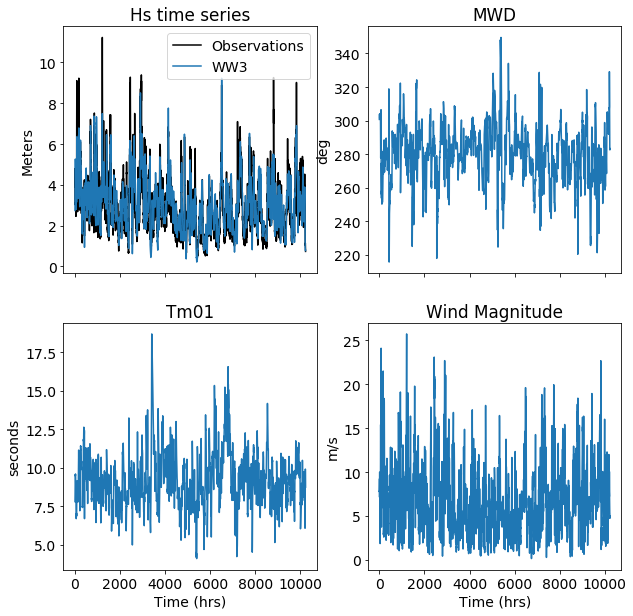

In [26]:
from sklearn import tree
import pickle
import pandas as pd
import matplotlib.pyplot as pl
import matplotlib.cm as cmx
from matplotlib import colors as colors
import scipy.io as sio
import matplotlib as mpl
import numpy as np


basic_cols=['#ff0000','k','#07076b']
my_cmap=colors.LinearSegmentedColormap.from_list('mycmap', basic_cols)

#Load the data. This data has already been cleaned - data gaps, either due to poor observations or gaps in wave forecasts
#have been removed. Choose either the winter dataset or the summer dataset. 
featmat = sio.loadmat('uncertaintyanalysis/winter_allfeatures_allyears.mat')

#The features are an array where the first three columns are hourly data points Hs, MWD, Tm output by WW3 at NDBC Buoy 46050 
#and the second two columns are wind magnitude and wind direction output by GFS and input into WW3. 

train_features = featmat['train_features'][:]
print("The input features are an array of shape " + str(train_features.shape)) #Note the shape MxN, where M = number of hours and N = number of features

#The train target are the hourly corrections (hourly deviations) between the WW3 output 
#and the observed wave height at NDBC Buoy 46050
train_target = featmat['train_target'][:]
train_target = train_target.squeeze()


#Visualize the time series before visualizing the feature space:
fig, ax = pl.subplots(2,2, sharex = True)
fig.set_size_inches(10,10)
ax[0,0].plot(train_obs, label = 'Observations', color = 'k')
ax[0,0].plot(train_features[:,0], label = 'WW3')
ax[0,0].set_title('Hs time series')
ax[0,0].legend()

ax[0,0].set_ylabel('Meters')

ax[0,1].plot(train_features[:,1])
ax[0,1].set_title('MWD')
ax[0,1].set_ylabel('deg')

ax[1,0].plot(train_features[:,2])
ax[1,0].set_ylabel('seconds')
ax[1,0].set_title('Tm01')
ax[1,0].set_xlabel('Time (hrs)')

ax[1,1].plot(train_features[:,3])
ax[1,1].set_ylabel('m/s')
ax[1,1].set_title('Wind Magnitude')
ax[1,1].set_xlabel('Time (hrs)')

## Data As Feature Space 

When the decision tree processes the data, it does not see the data as a continuous time series, but rather as a static feature space where the data are plotted against each other and with respect to the target value.

(0.0, 1.0, 0.0, 1.0)

/Users/ashleyellenson/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


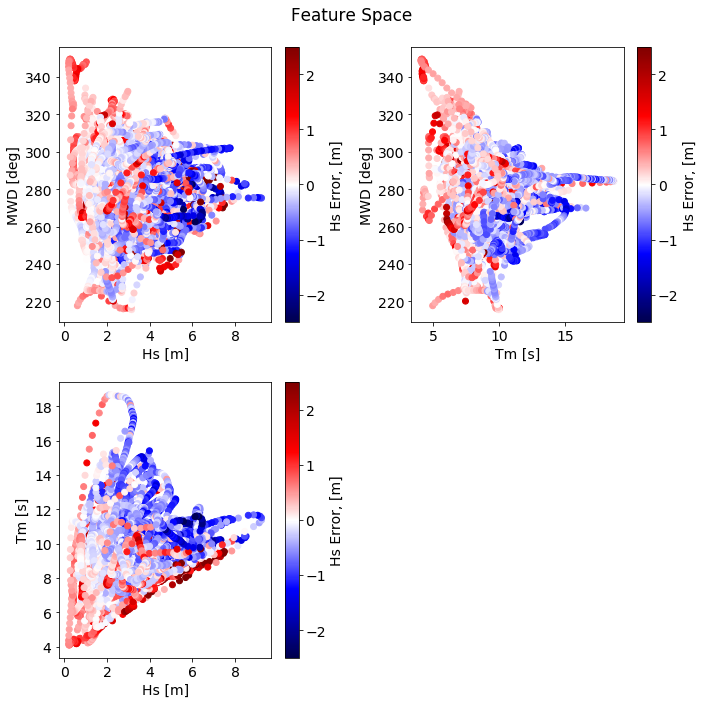

In [29]:
##This section of code plots the training data as a feature space.
mpl.rcParams['font.size'] = 14

features = ['Hs [m]','MWD [deg]','Tm [s]']
fig,ax = pl.subplots(2,2, tight_layout = {'rect':[0,0,1,0.95]})
fig.suptitle('Feature Space')
fig.set_size_inches(3,3)
fig.set_size_inches(10,10)
for feat in range(3):
    if feat == 0:
        f1 = 0
        f2 = 1
        a1 = 0
        a2 = 0
    if feat == 1:
        f1 = 2 
        f2 = 1
        a1 = 0
        a2 = 1
    if feat == 2:
        f1 = 0 
        f2 = 2
        a1 = 1
        a2 = 0
    im = ax[a1,a2].scatter(train_features[:,f1], train_features[:,f2],c = train_target, cmap  = 'seismic', vmin = -2.5, vmax = 2.5)
    c = fig.colorbar(im, ax = ax[a1,a2])
    c.set_label('Hs Error, [m]')
    ax[a1,a2].set_xlabel(features[f1])
    ax[a1,a2].set_ylabel(features[f2])
ax[1,1].axis('off')


# Implementing a Bagged Regression Tree in Scikit Learn

In the following sectiong, scikit-learn is used to train and test a decision tree. Once the decision tree is trained and tested, the theory behind the decision making can be understood by inspecting the architecture of the tree. 

Because the data is continuous, a regression tree as opposed to a decision tree (which is used for classification) will be used. Many trees are used as an ensemble, where the examples are pulled with replacement in a bagging technique. Five-fold cross-validation is used to find the optimal bagged tree parameters (including tree size and depth). 

Several key functions are called:

1. RandomForestRegressor : the base learner, or the regression tree itself
2. BaggingRegressor : the ensemble technique
3. GridSearchCV : the cross-validation routine to find the optimal decision tree parameters. 

For the paper, this routine was repeated 30 times, since each bagged regression tree is unique due to the stochastic nature of the routine. In this notebook, the routine is called just two times. 


Training now
Run 0took 1.0967020988464355seconds featuring Hs_ww3 mwd_ww3 Tm_ww3
Run 1took 1.0275201797485352seconds featuring Hs_ww3 mwd_ww3 Tm_ww3
Total time is 2.126852035522461
RMSE for WW3 is 0.6340467504203599
RMSE for DT is 0.5795512754581835


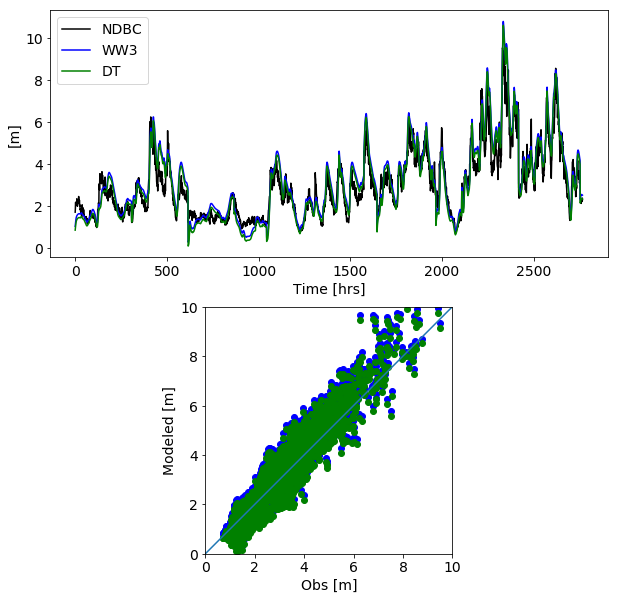

In [52]:
from sklearn.ensemble import BaggingRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import io
import os
import random
import sys
import time
import Error

#Things to change when you first log in:
start = time.time()
#Number of realizations. Because each time a regression tree forest is created is a random realization, many realizations are made
no_runs = 2
testbuoy = '46050'

#Even though we loaded the data earlier, the data is reloaded again here in case the earlier modules were skipped. 

all_data = sio.loadmat('uncertaintyanalysis/winter_allfeatures_allyears.mat')

#All the possible train feature names are Hs_ww3, mwd_ww3, Tm_ww3, wndmag, and wnddir
#Load the train features and choose which features you want as a list in the "train feature names"
trainfeaturenames = ['Hs_ww3','mwd_ww3','Tm_ww3']
train_features = all_data['train_features'][:]#Entire feature set, where the columns are Hs_ww3, MWD_ww3, Tm_ww3, windmag, winddir
train_target = all_data['train_target'][:]#Corrections (deviations from buoy readings)
train_target = train_target.squeeze()
train_features = train_features[:,0:len(trainfeaturenames)]

train_target = train_target

test_features = all_data['test_features'][:]
test_target = all_data['test_target'][:]
test_target = test_target.squeeze()

test_features = test_features[:,0:len(trainfeaturenames)]

ww3_hs_test = test_features[:,0] #The first column of the feature set is Hs. 
obs_hs_test = ww3_hs_test + test_target #Recover the observations by adding back the corrections
test_target = test_target


#Number of folds for the cross-fold validation
no_folds = 5

#Set up the inputs for the GridSearchCV function
#depths = [5,10,15,20,30,50,70]
#treenos = [10,30,50,100,150,200,250,275,300,350,400,500]
depths = [2,5] #depths to test
treenos = [5,10] #number of trees to test
opt_params = {'base_estimator__max_depth':depths,'n_estimators':treenos}

#Set up final data frames which will need to be saved
#Importance values for each feature
nandata = np.ones((no_runs,train_features.shape[1]))*np.nan
feature_importance_matrix = pd.DataFrame(nandata, columns = trainfeaturenames)

#Optimal parameters for each run
nandata = np.ones((no_runs,2))*np.nan
forest_parameter_matrix = pd.DataFrame(nandata,columns = ['depth','number'])

#Training error
nandata = np.ones((no_runs,5))*np.nan
training_error_df = pd.DataFrame(nandata,columns = ['RMSE','bias','PE','SI','Corr_Coeff'])

#Final corrections for each run. The mean of this matrix will be taken as the final corrections.
DT_var_matrix = np.ones((no_runs,len(ww3_hs_test)))*np.nan

#All ready to train! 
print("Training now")
for runno in range(no_runs):
    t0_run = time.time()

    #Use gridsearch CV with "Bagging Regressor" - the ensemble technique and the "Decision Tree Regressor" - the base learner - nested inside. 
    DT_cv = GridSearchCV(BaggingRegressor(base_estimator = tree.DecisionTreeRegressor()), opt_params, cv = 5, scoring = 'neg_mean_absolute_error', iid = False)
    
    #GridSearchCV has returned an object where the best parameters are automatically selected in DT_cv
    #Now we can fit the tree to the training data
    DT_cv.fit(train_features,train_target)

       
    #Save out forest parameters
    forest_parameter_matrix.iloc[runno]['depth'] = DT_cv.best_estimator_.base_estimator.max_depth
    forest_parameter_matrix.iloc[runno]['number'] = DT_cv.best_estimator_.n_estimators

    bestDT = DT_cv.best_estimator_

    #Record the importances
    importances = [x.feature_importances_ for x in bestDT.estimators_]
    importance_df = pd.DataFrame(importances, columns = trainfeaturenames)
    feature_importance_matrix.iloc[runno] = importance_df.describe().loc['mean'].values


    DT_corrections = DT_cv.predict(test_features)

    #make the ultimate prediction using decision tree corrections
    DT_var_matrix[runno,:] = DT_corrections
    t1_run = time.time()
    timedifference = t1_run - t0_run
    
    print("Run " + str(runno) + "took " + str(timedifference) + "seconds featuring " + " ".join(trainfeaturenames))
end = time.time()

totaltimediff = end-start
print("Total time is " + str(totaltimediff))

#Save the best tree to explore later. 
best_DT = DT_cv.best_estimator_
DT_pickle = open('./ExampleDT.pickle', 'wb')
pickle.dump(best_DT, DT_pickle)
DT_pickle.close()

#Calculate the mean corrections from the runs for the final corrections. 
meancorrections = np.mean(DT_var_matrix) 
dt_hs = ww3_hs_test + meancorrections

WW3Error = np.zeros((4,1))
DTError = np.zeros((4,1))
WW3Error = Error.getStats(obs_hs_test, ww3_hs_test)
DTError = Error.getStats(obs_hs_test, dt_hs)

#Visualize the results:
fig, ax = pl.subplots(2,1)
fig.set_size_inches(10,10)
ax[0].plot(obs_hs_test, color = 'k', label = 'NDBC')
ax[0].plot(ww3_hs_test, color = 'blue', label = 'WW3')
ax[0].plot(dt_hs, color = 'green', label = 'DT')
ax[0].legend()
ax[0].set_ylabel('[m]')
ax[0].set_xlabel('Time [hrs]')

ax[1].scatter(obs_hs_test, ww3_hs_test, color = 'blue')
ax[1].scatter(obs_hs_test, dt_hs, color = 'green')
ax[1].set_xlabel('Obs [m]')
ax[1].set_ylabel('Modeled [m]')
ax[1].set_xlim((0,10))
ax[1].set_ylim((0,10))
ax[1].plot((0,10),(0,10))
ax[1].set_aspect('equal')

print("RMSE for WW3 is " + str(WW3Error[0]))
print("RMSE for DT is " + str(DTError[0]))

 # Exploring the Decision Tree #
 
  This section will show how the bagged regression tree made decisions, and how to apply the bagged regression tree in a descriptive way by using its architecture. 
  
## The Theory behind Decision Making ##
 
 ### Objective Function and Partitioning Data ### 

 
> The objective of the bagged regression tree is to partition the dataset as a feature space. It attempts to find the partitions of the feature space wherein the mean target value of that partition ($\overline{y}(t)$) is most similar to the rest of the target values encompassed within that partition. Specifically, the algorithm seeks the partitions, t, in the entire dataset, T, that minimize the sum of variances in $y_i$ across all the partitions: 
\begin{equation}
\frac{1}{N}\sum_{t\in{T}}\sum_{\mathbf{x}_i\in{t}}{(y_i - \overline{y}(t))^{2}}
\end{equation}
 These partitions are constructed by splitting the target values ${(y_i)}$ with respect to values of the input features ${(\mathbf{x}_i)}$. During the training phase, the regression tree establishes partitions.  See the figure below for an example of how the data is successively split on threshold values of input features, establishing a tree structure. During the testing phase, the regression tree classifies an instance into a partition based on the values of the associated input features (${\mathbf{x}_i}$). The mean target value associated with that partition is then made the prediction for that instance. See the code below for a demonstration of how to plot the final partitions, $\mathbf{t}$, made relative to the entire dataset $T$.

In the following code, the four most populated partitions established by one regression tree in the entire forest is plotted. 
  

## Bagged Regression Tree Structure ##

An example tree is depicted below. Splits are made at nodes, and final partitions are leaves and those are the values that are assigned to the test instance. 

>Representative tree structure of the splits made between the input features during training on the training data set. This decision tree has a depth of 5, meaning that five decisions are made to split the target values into 62 final partitions (not all pictured). The input features (mean wave period, $Tm01$, mean wave direction, $MWD$ and significant wave height, $Hs$) are indicated within each final tree node with a threshold value. Branches to the left (right) represent the division of data points less than (greater than) the threshold value. In the final partitions, MSE is the mean squared error between the member target values within the partition and the mean target value associated with that partition. The MSE is the value which the decision tree seeks to minimize overall the partitions in determining how to split the data space. $\overline{y}(t)$ is the mean target value associated with that partition.  During testing, $\overline{y}(t)$ is made the prediction for the instances which fall into that final partition. Instances fall into the partition because the value of the input features, $\mathbf{x_i}$, correspond with the thresholds determined during training.

<img src = 'uncertaintyanalysis/DecisionTree_Example.png'>

When the decision tree splits more on one feature than another, this indicates that the feature is better correlated with the target than the other input features. In this case, the target is the error between the wave data and the buoys.  

     Hs_ww3   mwd_ww3    Tm_ww3
0  0.394547  0.089863  0.515590
1  0.388390  0.097128  0.514482


Text(0.5,1,'Feature Importance')

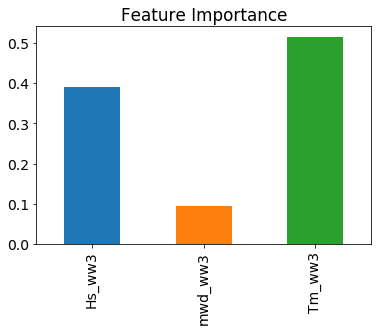

In [49]:
#The feature importance matrix columnns are the input features, and the rows indicate the run number. 
# The numbers sum to 1 and show the relative importance of each feature. 
print(feature_importance_matrix)

fig, ax = pl.subplots(1,1)
feature_importance_matrix.mean().plot(kind = 'bar')
ax.set_title('Feature Importances')

### Bagged Regression Tree Parameters ###

>The number of splits made on a learning data set is referred to as the depth of a tree, and the number of trees used to make the final prediction in the bagged regression tree is the size. The size and depth of each bagged regression tree is determined during the training phase through cross validation, as described by \cite{breiman1992submodel}, and in the following section. Also, a tree might split on one feature more often than another, indicating that the feature is important in its decision making rules. 

   depth  number
0    5.0    10.0
1    5.0    10.0
The best mean DT depth is 5.0
The best mean number of DT is 10.0


Text(0.5,1,'Optimal Bagged Regression Tree Parameters')

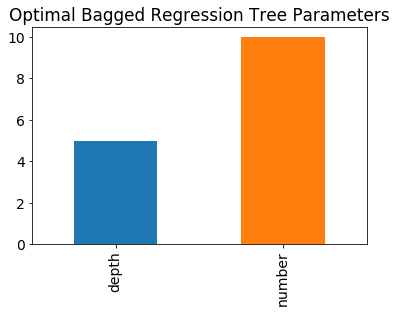

In [104]:
#For each run, the best depth/number of tree combination was saved in the forest parameter matrix. 

print(forest_parameter_matrix)

print("The best mean DT depth is " + str(forest_parameter_matrix['depth'].mean()))
print("The best mean number of DT is " + str(forest_parameter_matrix['number'].mean()))

pl.figure()
forest_parameter_matrix.mean().plot(kind= 'bar')
pl.title('Optimal Bagged Regression Tree Parameters')

(0.0, 1.0, 0.0, 1.0)

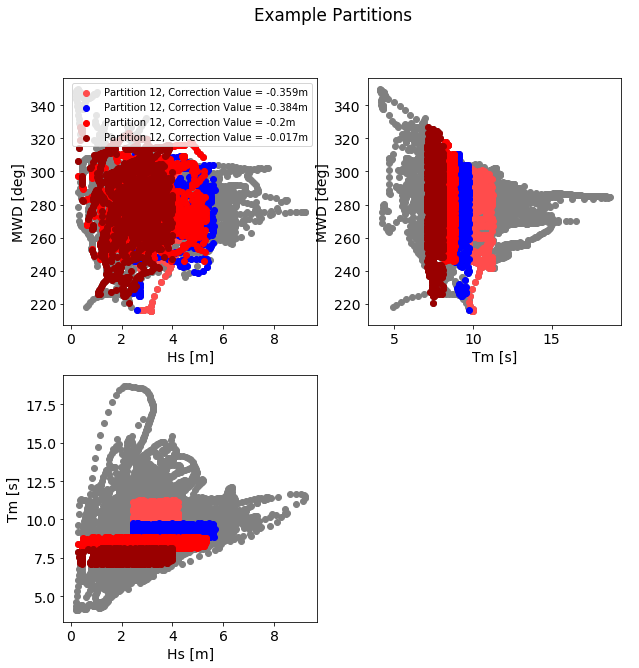

In [86]:
DT_pickle = open('./ExampleDT.pickle','rb')
bestDT = pickle.load(DT_pickle)
DT_pickle.close()
#Choose an estimator to inspect
estimator = bestDT.estimators_[0]

# Find the final leaf numbers or partition IDs for the training data. 
#Can choose to use train features or test features:

inputdata = train_features #or choose to look at how the decision tree performs with the unseen (testing)
target = train_target
leaf_ids = estimator.apply(inputdata) 

#Find the most populated partitions and choose the top 4 populated partitions
bins = np.arange(0,65)
hist_ids = np.argsort(np.histogram(leaf_ids,bins)[0]) #Find the most populated leaves by which examples share the same leaf ID number.
numexs, leafids = np.histogram(leaf_ids, bins)
leafids = leafids[hist_ids]
topleaf_ids = leafids[-4:] #Choose the top 4 populated leaves to visualize
colors = ['#ff4c4c','#0000ff','#ff0000','#990000']

#Target values applied to each partition
correction_vals = [np.float(np.round(estimator.tree_.value[ll][0][0],3)) for ll in topleaf_ids]



fig,ax = pl.subplots(2,2)
fig.suptitle('Example Partitions')
fig.set_size_inches(10,10)
for feat in range(3):
    if feat == 0:
        f1 = 0
        f2 = 1
        a1 = 0
        a2 = 0
    if feat == 1:
        f1 = 2 
        f2 = 1
        a1 = 0
        a2 = 1
    if feat == 2:
        f1 = 0 
        f2 = 2
        a1 = 1
        a2 = 0
    ax[a1,a2].scatter(inputdata[:,f1], inputdata[:,f2],color = 'grey')
    ax[a1,a2].set_xlabel(features[f1])
    ax[a1,a2].set_ylabel(features[f2])


    for ii in range(4):
        #Find the indices of the leaf for each partition. 
        leafidx = np.where(leaf_ids == topleaf_ids[ii])[0]
        ax[a1,a2].scatter(inputdata[leafidx,f1], inputdata[leafidx,f2],color = colors[ii], label = 'Partition ' + str(leaf_ids[ii]) + ", Correction Value = " + str(np.round(correction_vals[ii],3)) + 'm')
        if feat == 0:
            ax[a1,a2].legend(fontsize  = 10)

ax[1,1].axis('off')

### Plot a Partition

We'll choose the most populated partition to explore. This is the region of the model which the bagged regression tree has found to have most repeated model error: 

Text(0.5,0.98,'Most Populated Leaf Correction Value of -0.36 \n WW3 RMSE = 0.59 \n DT RMSE = 0.46')

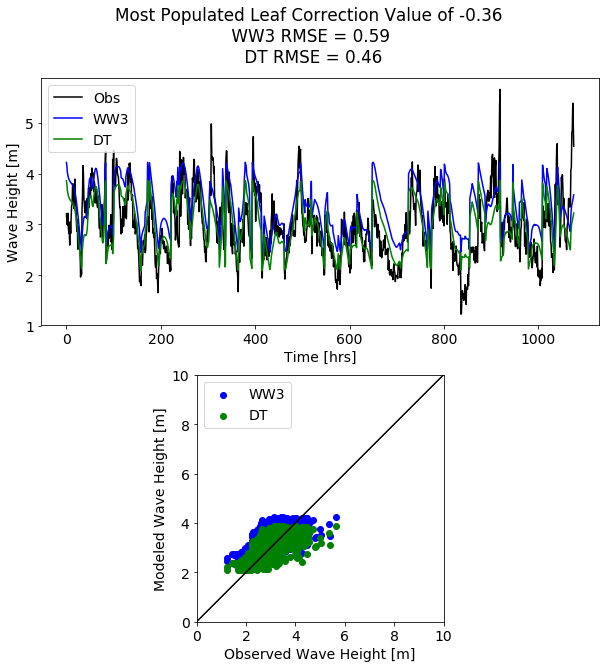

In [101]:
#Pull the top leaf IDs and find those members, then recover Hs and plot
most_populated_leafID = topleaf_ids[0]
leaf_members = np.where(leaf_ids == most_populated_leafID)[0]
correction = estimator.tree_.value[most_populated_leafID][0][0] #What was the correction applied to these members

ww3_hs = inputdata[leaf_members,0]
obs_hs = inputdata[leaf_members,0] + target[leaf_members]
dt_hs = inputdata[leaf_members,0] + correction

WW3Error = np.zeros((4,1))
DTError = np.zeros((4,1))
WW3Error = Error.getStats(obs_hs, ww3_hs)
DTError = Error.getStats(obs_hs, dt_hs)


fig, ax = pl.subplots(2,1)
fig.set_size_inches((10,10))
ax[0].plot(obs_hs, color = 'k',label = 'Obs')
ax[0].plot(ww3_hs, color = 'blue', label = 'WW3')
ax[0].plot(dt_hs, color = 'green', label = 'DT')
ax[0].set_xlabel('Time [hrs]')
ax[0].set_ylabel('Wave Height [m]')
ax[0].legend()

ax[1].scatter(obs_hs, ww3_hs, color = 'blue', label = 'WW3')
ax[1].scatter(obs_hs,dt_hs, color = 'green', label = 'DT')
ax[1].set_xlim((0,10))
ax[1].set_ylim((0,10))
ax[1].plot((0,10),(0,10), color = 'k')
ax[1].legend()
ax[1].set_xlabel('Observed Wave Height [m]')
ax[1].set_ylabel('Modeled Wave Height [m]')
ax[1].set_aspect('equal')
fig.suptitle('Leaf Correction Value of {0:2.2f} \n WW3 RMSE = {1:2.2f} \n DT RMSE = {2:2.2f}'.format(correction,WW3Error[0], DTError[0]))



### Model Phase Space ###

To find the model phase space where this partition occurs, we trace the decisions made to partition out these examples. 

In [98]:
#Note that the following code is from scikit learn documentation
#Which region of model phase space are these examples from? 

n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold

node_indicator = estimator.decision_path(train_features)


sample_id = leaf_members[0] #Choose a sample from the leaf
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]


print('Input Feature Phase Space: ' % sample_id)
for node_id in node_index:
    if leave_id[sample_id] == node_id:
        continue

    if (train_features[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("%s %s %s)"
          % (trainfeaturenames[feature[node_id]],
             threshold_sign,
             threshold[node_id]))

Input Feature Phase Space: 
Tm_ww3 > 8.854768753051758)
Hs_ww3 > 2.442129611968994)
Tm_ww3 > 9.743279457092285)
Hs_ww3 <= 4.228293418884277)
Tm_ww3 <= 11.257381439208984)
